In [1]:
import os

In [12]:
%%capture
! pip install pytorch-lightning
! pip install lightning-bolts

In [2]:
#Majority of code copied from https://github.com/Lightning-Universe/lightning-bolts/blob/master/src/pl_bolts/models/autoencoders/components.py
#however some part is edited to send onehotlabels
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F  # noqa: N812


class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate."""

    def __init__(self, size=None, scale_factor=None) -> None:
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return F.interpolate(x, size=self.size, scale_factor=self.scale_factor)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def resize_conv3x3(in_planes, out_planes, scale=1):
    """Upsample + 3x3 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes))


def resize_conv1x1(in_planes, out_planes, scale=1):
    """Upsample + 1x1 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes))


class EncoderBlock(nn.Module):
    """ResNet block, copied from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L35."""

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None) -> None:
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        return self.relu(out)


class EncoderBottleneck(nn.Module):
    """ResNet bottleneck, copied from
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L75."""

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None) -> None:
        super().__init__()
        width = planes  # this needs to change if we want wide resnets
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        return self.relu(out)


class DecoderBlock(nn.Module):
    """ResNet block, but convs replaced with resize convs, and channel increase is in second conv,
    not first."""

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None) -> None:
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        return self.relu(out)


class DecoderBottleneck(nn.Module):
    """ResNet bottleneck, but convs replaced with resize convs."""

    expansion = 4

    def __init__(self, inplanes, planes, scale=1, upsample=None) -> None:
        super().__init__()
        width = planes  # this needs to change if we want wide resnets
        self.conv1 = resize_conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = resize_conv3x3(width, width, scale)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.upsample = upsample
        self.scale = scale

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        return self.relu(out)


class ResNetEncoder1(nn.Module):
    def __init__(self, block, layers, first_conv=False, maxpool1=False) -> None:
        super().__init__()

        self.inplanes = 64
        self.first_conv = first_conv
        self.maxpool1 = maxpool1

        if self.first_conv:
            self.conv1 = nn.Conv2d(
                13, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
            )
        else:
            self.conv1 = nn.Conv2d(
                13, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
            )

        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        if self.maxpool1:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, one_hot_labels):
        one_hot_labels = (
            one_hot_labels.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        )
        x = torch.cat([x, one_hot_labels], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x


class ResNetDecoder1(nn.Module):
    """Resnet in reverse order."""

    def __init__(
        self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False
    ) -> None:
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

        if self.maxpool1:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
            self.upscale_factor *= 2
        else:
            self.layer4 = self._make_layer(block, 64, layers[3])

        if self.first_conv:
            self.upscale = Interpolate(scale_factor=2)
            self.upscale_factor *= 2
        else:
            self.upscale = Interpolate(scale_factor=1)

        # interpolate after linear layer using scale factor
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(
            64 * block.expansion, 3, kernel_size=3, stride=1, padding=1, bias=False
        )

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, one_hot_labels):
        # one_hot_labels = one_hot_labels.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))

        x = torch.cat([x, one_hot_labels], dim=1)

        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)
        return self.conv1(x)

def resnet18_encoder(first_conv, maxpool1):
    return ResNetEncoder1(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)


def resnet18_decoder(latent_dim, input_height, first_conv, maxpool1):
    return ResNetDecoder1(
        DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1
    )


def resnet50_encoder(first_conv, maxpool1):
    return ResNetEncoder1(EncoderBottleneck, [3, 4, 6, 3], first_conv, maxpool1)


def resnet50_decoder(latent_dim, input_height, first_conv, maxpool1):
    return ResNetDecoder1(
        DecoderBottleneck, [3, 4, 6, 3], latent_dim, input_height, first_conv, maxpool1
    )



Lets train cifar module

In [8]:
import pytorch_lightning as pl
import lightning
from torch import nn
from torch.nn import functional as F


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, num_classes=10):
        super().__init__()

        self.save_hyperparameters()
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim + 10, input_height=input_height, first_conv=False, maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        self.num_classes = num_classes

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch
        one_hot_labels = F.one_hot(y, num_classes=self.num_classes)
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x, one_hot_labels)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z, one_hot_labels)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

#Loading Cifar Dataset

In [4]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [10]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(max_epochs=30, gpus=1)
trainer.fit(vae, datamodule)

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type           | Params
-------------------------------------------
0 | encoder | ResNetEncoder1 | 12.0 M
1 | decoder | ResNetDecoder1 | 8.7 M 
2 | fc_mu   | Linear         | 131 K 
3 | fc_var  | Linear         | 131 K 
-------------------------------------------
20.9 M    Trainable params
0         Non-trainable params
20.9 M    Total params
83.751    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


#Save model

In [11]:
# Save the trained model checkpoint
checkpoint_path = "model.ckpt"  # Specify your desired path
trainer.save_checkpoint(checkpoint_path)

In [12]:
# Load the saved model checkpoint
vae = VAE.load_from_checkpoint(checkpoint_path)

#Generating Data for visualization

In [21]:
vae = vae.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
import numpy as np
mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)
test_loader = datamodule.val_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_images = []
count = 0
for batch_idx, (images, labels) in enumerate(test_loader):
  original_label = labels
  data_iter = iter(test_loader)
  try:
      next_batch = next(data_iter)
      labels = next_batch[1]
  except StopIteration:
      # Handle the case where there are no more batches
      labels = None
  if count<25:
   if count>25:
    break
   count=count+1
   z = images
   y = labels
   y = F.one_hot(y, num_classes=10)
   # SAMPLE IMAGES
   x_encoded = vae.encoder(z.to(device), y.to(device))
   # x_encoded = torch.cat((x_encoded, one_hot_labels.to('cuda')), dim=1) #get OHE for label features
   mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

   # sample z from q
   std = torch.exp(log_var / 2)
   q = torch.distributions.Normal(mu, std)
   z = q.rsample()
   # print(z.shape,y.shape)
   with torch.no_grad():
      pred = vae.decoder(z.to(device), y.to(device)).to(device)

      # UNDO DATA NORMALIZATION
      # normalize = cifar10_normalization()
      #mean, std_data = np.array(mean), np.array(std)
      #img = make_grid(pred).permute(1, 2, 0).cpu().numpy() * std_data + mean
      output_images.append((pred, original_label, labels))

In [78]:
classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
images = []
orig = []
label = []
for i in range(32):
  if classes[output_images[1][1][i].item()] != classes[output_images[1][2][i].item()]:
   images.append(output_images[1][0][i].cpu())
   orig.append(classes[output_images[1][1][i].item()])
   label.append(classes[output_images[1][2][i].item()])


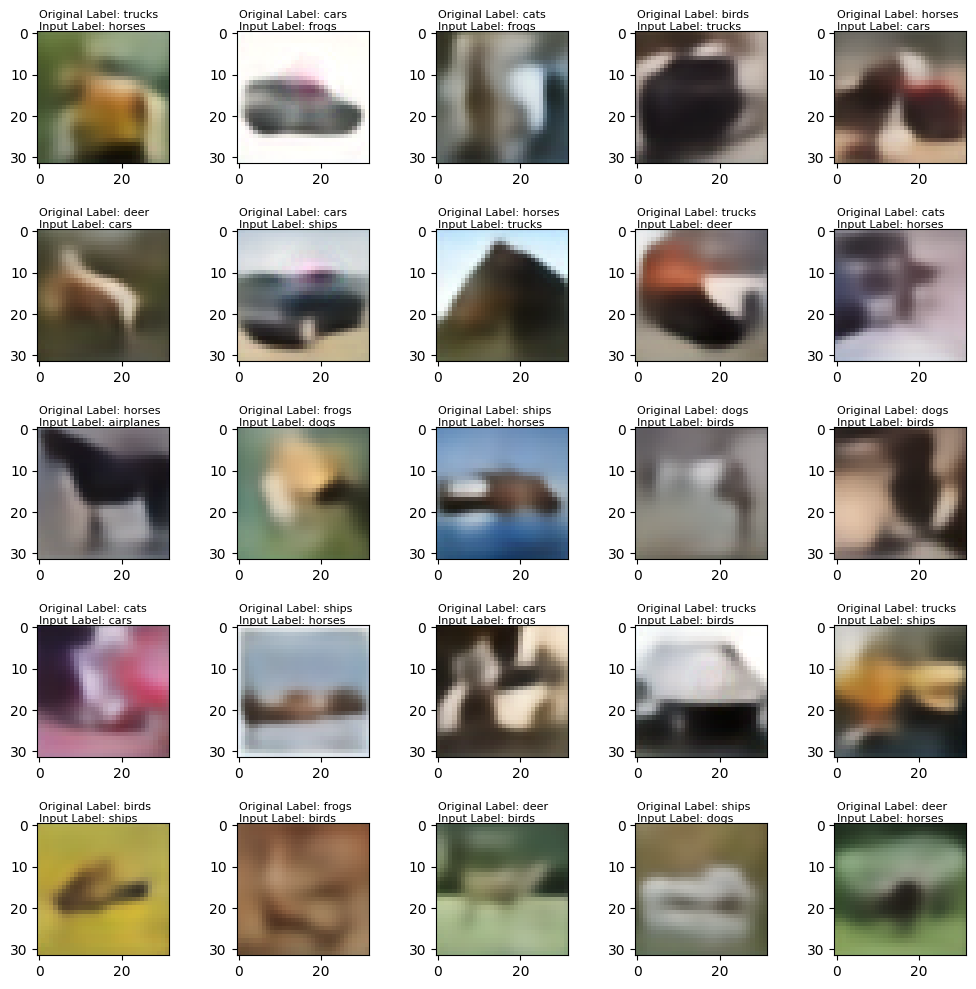

In [77]:
import matplotlib.pyplot as plt
import numpy as np  # Import NumPy

# Create a subplot grid for displaying the collected images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Plot each image in the grid and add labels horizontally before the image
for i in range(25):
    ax = axes[i // 5, i % 5]
    img = images[i]
    row = i // 5
    col = i % 5
    ax.imshow(np.transpose(img, (1, 2, 0)))  # Transpose the image data using NumPy
    # Add original label and next label as text before the image
    label_text = f"Original Label: {orig[i]} \n"
    label_text += f"Input Label: {label[i]}"
    ax.text(0, -1.0, label_text, fontsize=8)
# Show the plot
plt.show()